Dies ist das Programm, mit welchem es möglich ist das Puzzle zu "lösen"

Die Quelle für die Kommentare ist Google Gemini

In [6]:
# Die benötigten imports, damit python die benutzen kann
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
import numpy as np
from PIL import Image, ImageDraw, ImageFont, ImageFilter
from PIL.Image import Resampling

import matplotlib.pyplot as plt


In [7]:
# mit google drive verbinden
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# Die Variable saveModelFileName, welche den Dateinamen zu dem Modell hat, die anderen sind auskommentiert, da diese gerade nicht gebraucht werden
saveModelFileName = "/content/drive/Shareddrives/Models/epochen1000_128fil_64img_rgb.keras"

# die Image size muss immer angepasst werden je nach Modell, also ob es 128 oder 64 ist
IMG_SIZE = 64
# aus der Variable IMG_SIZE wird nun die Fläche der Bilder gebildet, also entweder 128x128 Pixel oder 64x64 Pixel
image_size = (IMG_SIZE, IMG_SIZE)

# der usedColorMode ist entweder rgb oder grayscale
#usedColorMode = "grayscale"
usedColorMode = "rgb"

# Variable mit dem Pfad zu den Testbildern
testDir = "/content/drive/Shareddrives/Testbilder/Puzzle_Lösen/"

# keras.models.load_model ist die Funktion, welche Modelle laden kann, hier aus der Variable saveModelDir, welche am Anfang definiert wurde mit einem Pfad zum Modell
model = keras.models.load_model(saveModelFileName)
# model.summary ist eine Funktion Keras, welche einen Überblick das Modell gibt.
# Im Genaueren also dessen Struktur und die Parameter. Es werden die einzelnen Schichten (Layers) deren Ausgabenformen (Output Shape) und die Anzahl der Parameter (Param) von den Schichten angezeigt
# Zu dem wird die Gesamtzahl der Parameter vom ganzen Modell gezeigt aufgeteilt in die trainierbaren Parameter und die nicht-trainierbaren Parameter
model.summary()



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 128)         │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       8,388,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 18)                  │           1,170 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,623,032 (97.74 MB)

 Trainable params: 8,541,010 (32.58 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,082,022 (65.16 MB)

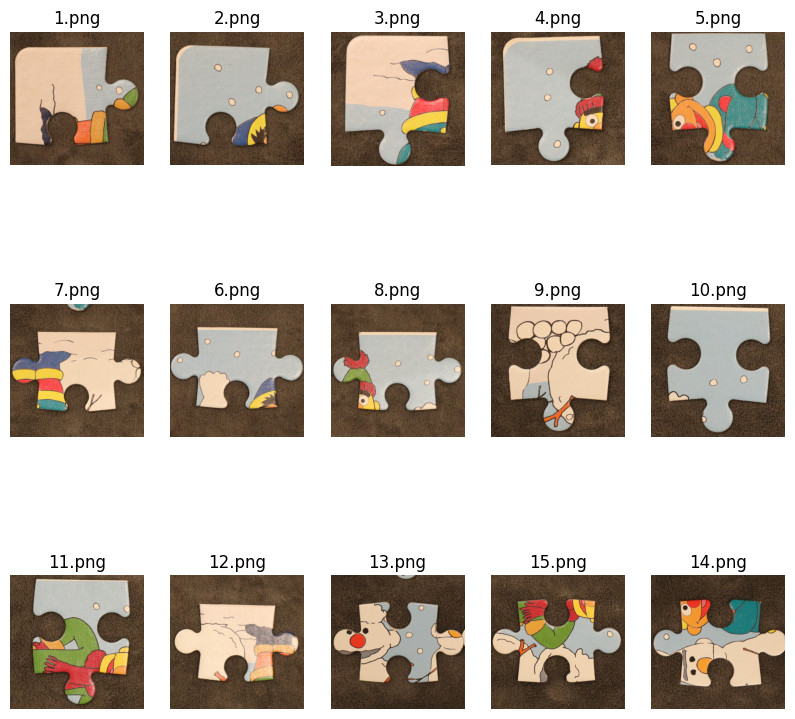

In [9]:
# Die Testbilder werden in einer Liste in der Variablen testFiles verstaut
testFiles = os.listdir(testDir)

# Eine neue Figur wird durch Matplotlib hergestellt, die Grösse ist 10x10 inches
plt.figure(figsize=(10,10))
# Die Variable curImage ist eine Zählvariable, welche auf 1 gesetzt wird
curImage = 1

# Durchgehen aller Dateien im Ordner testdir, der weiter oben ausgewählt wird
for curFile in testFiles:
    # hier wird der Patch von testDir mit dem Dateinamen curFile kombiniert
    bild_fname = testDir + curFile
    # Das Bild wird geöffnet durch die Funktion Image.open und wird dann in der Variable orgimg verstaut
    orgimg = Image.open(bild_fname)

    # Ein Subplot wird innerhalb der Figur hergestellt mit 3 Zeilen und 5 Spalten, die Variable curImage gibt den Ort an, wo der aktuelle Subplot ist
    ax = plt.subplot(3,5,curImage)
    # Die Variable curImage wird um 1 erhöht, damit bei der nächsten Iteration zum nächsten Subplot wander
    curImage += 1
    # Das Bild von der Variable orgimg wird im aktuellen Subplot angezeigt
    plt.imshow(orgimg)

    # Der Titel des Subplots wird festgelegt durch die Variable curFile, diese hat den Wert des Bildes gespeichert, also so wie dessen Namen
    plt.title(curFile)
    # Die Achsenbeschriftung für den aktuellen Subplot wird ausgeblendet
    plt.axis("off")



Der folgende Code ist in Zusammenarbeit mit meinem Vater entstanden.

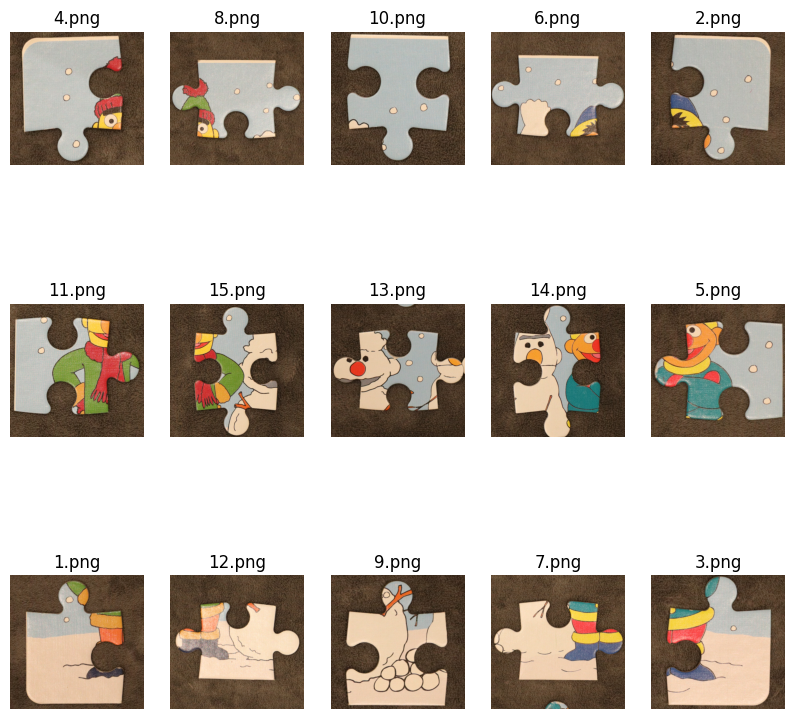

In [10]:
# Klassennamen für die Zuordnung der verschiedenen Klassen zu Zahlen 0...17 (18 Klassen) für die spätere Verarbeitung in Tabellenform
classnames = ['010', '020', '030', '040', '050', '060', '070', '071', '080', '081', '090', '091', '100', '110', '120', '130', '140', '150']

# Ordner mit den Testbildern einlesen
testFiles = os.listdir(testDir)

plt.figure(figsize=(10,10))

curImage = 1

# Durchgehen aller Dateien im Ordner testdir, der weiter oben ausgewählt wird
for curFile in testFiles:

      bild_fname = testDir + curFile
      # Laden des Bildes mit dem Dateinamen bild_fname mit entweder rgb oder grayscale colormode und mit der gewünschten Auflösung. Die Bilder, welche können höher aufgelöst seind, werden hier dann skaliert
      img = tf.keras.utils.load_img(
          bild_fname,
          color_mode=usedColorMode,
          target_size=(IMG_SIZE, IMG_SIZE)
      )
      # creating a image object (main image)
      orgimg = Image.open(bild_fname)
      # Das Image in ein Feld (array) umbauen, denn keras arbeitet nur mit diesen array.
      # Bei Trainieren des Models ist das von der Function tf.keras.utils.image_dataset_from_directory "miterledigt" worden
      img_array = tf.keras.utils.img_to_array(img)
       # ein array von bildern anlegen, das aber nur 1 Bild enthält. Die folgende model.predict function braucht als Eingabe so ein Array, deshalb dieser Umweg
      img_array = tf.expand_dims(img_array, 0)

      # Berechnet die Prediction für das gerade geladene Bild
      predictions = model.predict(img_array,verbose=0)
      # Beispiel für eine predictions, die in der Zeile vorher berechnet wurde. Man sieht die 18 Bewertungen für die 18 Klassen
      #[[14229 -6334 3480 2634 -784 -6531 -4458 -7535 -6561 630 -2632 -6097 2005 -3240 2218 -4952 -5617
      #  4911]]

      # berechnet den score aus der prediction mit der softmax methode
      score = tf.nn.softmax(predictions[0])
      # Beispiel für den score aus dem prediction Beispiel
      # Man sieht das Klasse 1 den höchsten Wert (14229) hat und natürlich hat im tensor die position 1 eine 1, alle anderen 17 sind 0
      # tf.Tensor([ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0], shape=(18,), dtype=float32)

      # mit numpy wird jetzt die position der 1 bestimmt, ist in unserem Fall die 0, denn das Zählen beginnt ja bei 0 bis 17
      predictedClass = np.argmax(score)

      # Nun wird der gespeicherte Wert in der Variabe predictedClass ausgewertet
      # es ist wie ein Sortiersystem, es wird durchgegangen, zu welchem case der Wert in predictedClass passt, also wenn der Wert gleich 0, dann wird der Code unter case 0 ausgeführt
      # Dieses System wird mit allen Werten in der Variablen gemacht
      match predictedClass:
          case 0:
              curImage = 1
              labelText = "{} ist die Ecke oben links".format(curFile)
          case 1:
              curImage = 2
              labelText = "{} ist das 2. von links oberste Reihe".format(curFile)
          case 2:
              curImage = 3
              labelText = "{} ist das 3. von links oberste Reihe".format(curFile)
          case 3:
              curImage = 4
              labelText = "{} ist das 4. von links oberste Reihe".format(curFile)
          case 4:
              curImage = 5
              orgimg = orgimg.rotate(270)
              labelText = "{} ist die Ecke oben rechts".format(curFile)
          case 5:
              curImage = 6
              orgimg = orgimg.rotate(90)
              labelText = "{} ist die 2. Reihe ganz links".format(curFile)
          case 6:
              curImage = 7
              orgimg = orgimg.rotate(90)
              labelText = "{} ist das 2. von links 2. Reihe 90 Grad CCW".format(curFile)
          case 7:
              curImage = 7
              orgimg = orgimg.rotate(270)
              labelText = "{} ist das 2. von links 2. Reihe 90 Grad CW".format(curFile)
          case 8:
              curImage = 8
              labelText = "{} ist das 3. von links 2. Reihe".format(curFile)
          case 9:
              curImage = 8
              orgimg = orgimg.rotate(180)
              labelText = "{} ist das 3. von links 2. Reihe 180 Grad gedreht".format(curFile)
          case 10:
              curImage = 9
              orgimg = orgimg.rotate(90)
              labelText = "{} ist das 4. von links 2. Reihe 90 Grad CCW".format(curFile)
          case 11:
              curImage = 9
              orgimg = orgimg.rotate(270)
              labelText = "{} ist das 4. von links 2. Reihe 90 Grad CW".format(curFile)
          case 12:
              curImage = 10
              orgimg = orgimg.rotate(270)
              labelText = "{} ist die 2. Reihe ganz rechts".format(curFile)
          case 13:
              curImage = 11
              orgimg = orgimg.rotate(90)
              labelText = "{} ist die Ecke unten links".format(curFile)
          case 14:
              curImage = 12
              orgimg = orgimg.rotate(180)
              labelText = "{} ist das 2. von links unterste Reihe".format(curFile)
          case 15:
              curImage = 13
              orgimg = orgimg.rotate(180)
              labelText = "{} ist das 3. von links unterste Reihe".format(curFile)
          case 16:
              curImage = 14
              orgimg = orgimg.rotate(180)
              labelText = "{} ist das 4 von links unterste Reihe".format(curFile)
          case 17:
              curImage = 15
              orgimg = orgimg.rotate(180)
              labelText = "{} ist die Ecke unten rechts".format(curFile)
          case _:
              curImage = 1
              labelText = "{} konnte nicht zugeordnet werden".format(curFile)

      # Ein Subplot wird innerhalb der Figur hergestellt mit 3 Zeilen und 5 Spalten, die Variable curImage gibt den jetzt den Ort an, wo das aktuelle Bild im Puzzle hingehört
      # also 1 für oben links und 15 für unten rechts
      ax = plt.subplot(3,5,curImage)
      plt.imshow(orgimg)

      plt.title(curFile)
      plt.axis("off")
